#### Imports

In [20]:
import re
import pandas as pd
from io import StringIO
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import linregress
from scipy.stats import chi2_contingency
from matplotlib.lines import Line2D
from collections import defaultdict
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

DATA_ROOT = Path("../data/discord")

output_dir = "../img"
os.makedirs(output_dir, exist_ok=True) 

SECTION_TITLES = [
    "Accounts and Servers: Warnings & Temporary Interventions",
    "Accounts Disabled",
    "Servers Removed",
    "Appeals",
    "Reports",
    "NCMEC",
    "US Gov Info Requests",
    "International Government Information Requests",
    "Preservation Requests",
    "Emergency Requests"
]

MONTHS = {
    "jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6,
    "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12
}

#### Utils

In [22]:
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    # drop unnamed or fully empty columns
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
    df = df.dropna(axis=1, how="all")

    # clean columns
    df.columns = [c.strip() for c in df.columns]

    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].astype(str).str.replace(",", "", regex=False)
            df[col] = df[col].replace({"--": None, "nan": None, "": None})
            # numeric conversion
            try:
                df[col] = pd.to_numeric(df[col])
            except (ValueError, TypeError):
                # else leave as original string
                pass

    return df

def extract_report_period_from_name(path: Path) -> str:
    name = path.name

    # Match full or abbreviated month ranges with connectors and year
    pattern = (
        r'\b('
        r'(?:[A-Za-z]{3,9})'                # First month (e.g., Jan or January)
        r'(?:\s*[_\-\u2013–to]+\s*)'        # Separator: underscore, dash, en-dash, or "to"
        r'(?:[A-Za-z]{3,9})'                # Second month (e.g., Jun or June)
        r'\s*20\d{2}'                       # Year
        r')\b'
    )
    m = re.search(pattern, name, flags=re.IGNORECASE)
    if m:
        # Normalize spacing and connectors
        period = re.sub(r'[_\u2013–]+', '-', m.group(1))
        period = re.sub(r'\s*-\s*', ' - ', period)
        return period.strip().title()

    # Fallback: match single month + year
    m = re.search(r'\b([A-Za-z]{3,9}\s*20\d{2})\b', name)
    if m:
        return m.group(1).strip().title()

    # Fallback: year only
    m = re.search(r'(20\d{2})', name)
    return m.group(1) if m else name

def parse_report_csv(file_path):
    # read and clean lines
    with open(file_path, "r", encoding="utf-8-sig") as f:
        lines = [line.strip() for line in f if line.strip() != ""]

    section_indices = {}
    for i, line in enumerate(lines):
        clean_line = re.sub(r",+$", "", line).strip()
        if clean_line in SECTION_TITLES:
            section_indices[clean_line] = i

    ordered_sections = sorted(section_indices.items(), key=lambda x: x[1])

    sections_data = {}
    for idx, (title, start_idx) in enumerate(ordered_sections):
        end_idx = ordered_sections[idx + 1][1] if idx + 1 < len(ordered_sections) else len(lines)
        block = lines[start_idx + 1:end_idx]
        block = [l for l in block if l.strip(",")]
        if not block:
            continue
        try:
            df = pd.read_csv(StringIO("\n".join(block)))
            df = clean_dataframe(df)
            sections_data[title] = df
        except Exception as e:
            print(f"Could not parse section {title}: {e}")

    # # preview
    # for name, df in sections_data.items():
    #     print(f"\n=== {name} ===")
    #     print(df.head())

    return sections_data


def _period_sort_key(period: str):
    """Return (year, start_month) tuple for sorting period strings."""
    if not isinstance(period, str):
        return (0, 0)
    # extract year
    y_m = re.search(r'(20\d{2})', period)
    year = int(y_m.group(1)) if y_m else 0
    # find first month name in the string
    month_names = re.findall(r'([A-Za-z]{3,9})', period)
    start_month = 0
    for m in month_names:
        key = m[:3].lower()
        if key in MONTHS:
            start_month = MONTHS[key]
            break
    return (year, start_month)

# helper: parse period string -> start Timestamp
def period_start_ts(period_str):
    m_year = re.search(r'(20\d{2})', str(period_str))
    year = int(m_year.group(1)) if m_year else 1970
    month_names = re.findall(r'([A-Za-z]{3,9})', str(period_str))
    month = 1
    for m in month_names:
        key = m[:3].lower()
        if key in MONTHS:
            month = MONTHS[key]
            break
    return pd.Timestamp(year=year, month=month, day=1)

In [23]:
def load_all_reports(data_root: Path) -> pd.DataFrame:
    """Iterate all report folders and aggregate into one master DataFrame (sorted by period)."""
    records = []
    for folder in sorted(data_root.glob("Discord-Transparency-*")):
        for csv_path in folder.glob("*.csv"):
            period = extract_report_period_from_name(csv_path)
            print(f"Processing period: {period}")
            section_data = parse_report_csv(csv_path)
            records.append({"period": period, "dataframes": section_data})

    df = pd.DataFrame(records)
    if not df.empty:
        df["_sort_key"] = df["period"].apply(_period_sort_key)
        df = df.sort_values(by="_sort_key", ascending=True).reset_index(drop=True)
        df = df.drop(columns=["_sort_key"])
    return df

In [24]:
def build_all_periods_df_from_master(master_df):
    """
    Convert master_df (period, dataframes dict) into a long dataframe with one row per period x policy_category.
    It will try to extract 'Servers Removed' and 'Reports' tables and merge them.
    All numeric columns are coerced to integers where possible.
    """
    rows = []
    for _, row in master_df.iterrows():
        period = row['period']
        dfs = row.get('dataframes') or {}
        sr = dfs.get('Servers Removed')
        reps = dfs.get('Reports')

        if sr is None:
            continue

        # normalize column names
        sr = sr.rename(columns=lambda c: str(c).strip())
        # detect key columns
        cat_col = sr.columns[0]
        pro_cols = [c for c in sr.columns if 'proactiv' in c.lower()]
        rea_cols = [c for c in sr.columns if 'reactiv' in c.lower()]
        total_cols = [c for c in sr.columns if 'total' in c.lower() or 'total servers' in c.lower()]

        # pick first candidate or fallback to positional columns
        pro_col = pro_cols[0] if pro_cols else (sr.columns[1] if sr.shape[1] > 1 else None)
        rea_col = rea_cols[0] if rea_cols else (sr.columns[2] if sr.shape[1] > 2 else None)
        total_col = total_cols[0] if total_cols else None

        def to_num(val):
            if pd.isna(val):
                return np.nan
            v = str(val).strip().replace('"', '').replace("'", "")
            v = v.replace(',', '')
            try:
                return pd.to_numeric(v, errors='coerce')
            except Exception:
                return np.nan

        # prepare reports table lookup
        if reps is not None:
            reps = reps.rename(columns=lambda c: str(c).strip())

        for _, r in sr.iterrows():
            cat = str(r.get(cat_col, '')).strip()
            if not cat or cat.lower().startswith('total') or cat.lower().startswith('sum'):
                continue

            proactive = to_num(r.get(pro_col)) if pro_col is not None else np.nan
            reactive = to_num(r.get(rea_col)) if rea_col is not None else np.nan

            # determine servers_removed: prefer explicit total column, else sum proactive+reactive, else try any numeric column
            if total_col is not None:
                servers_removed = to_num(r.get(total_col))
            else:
                if not pd.isna(proactive) or not pd.isna(reactive):
                    p = 0 if pd.isna(proactive) else proactive
                    q = 0 if pd.isna(reactive) else reactive
                    servers_removed = p + q
                else:
                    found = np.nan
                    for c in sr.columns[1:]:
                        val = to_num(r.get(c))
                        if not pd.isna(val):
                            found = val
                            break
                    servers_removed = found

            # find matching reports entry if available
            reports_count = None
            if reps is not None and reps.shape[1] >= 2:
                rep_num_cols = [c for c in reps.columns if pd.api.types.is_numeric_dtype(reps[c]) or reps[c].astype(str).str.replace(',','').str.isnumeric().any()]
                if not rep_num_cols:
                    rep_num_cols = [reps.columns[1]]
                try:
                    matches = reps.iloc[:,0].astype(str).str.strip().str.lower() == cat.lower()
                    if matches.any():
                        rep_val = reps.loc[matches, rep_num_cols[0]].iloc[0]
                        reports_count = to_num(rep_val)
                except Exception:
                    reports_count = None

            rows.append({
                'period': period,
                'policy_category': cat,
                'servers_removed': servers_removed,
                'proactive': proactive,
                'reactive': reactive,
                # 'reports': reports_count
                'proactive_share': proactive / servers_removed,
                'reactive_share': reactive / servers_removed
            })

    all_df = pd.DataFrame(rows)
    all_df['policy_category'] = all_df['policy_category'].astype(str).str.strip()

    # assign chronological integer IDs to each period using _period_sort_key
    # sorted_periods will be in chronological order (earliest -> latest)
    unique_periods = all_df['period'].astype(str).unique().tolist()
    sorted_periods = sorted(unique_periods, key=_period_sort_key)
    period_id_map = {p: i + 1 for i, p in enumerate(sorted_periods)}  # start IDs at 1
    all_df['period_id'] = all_df['period'].map(period_id_map).astype('Int64')

    numeric_cols = ['servers_removed', 'proactive', 'reactive', 'reports']
    for col in numeric_cols:
        if col in all_df.columns:
            all_df[col] = pd.to_numeric(all_df[col], errors='coerce').astype('Int64')  # nullable integer type

    return all_df


def summarize_df_columns(df: pd.DataFrame, desc_map: dict | None = None, sample_n: int = 5) -> pd.DataFrame:
    rows = []
    n_rows = len(df)
    for col in df.columns:
        s = df[col]
        n_missing = int(s.isna().sum())
        pct_missing = (n_missing / n_rows) if n_rows else 0

        # safe unique extraction: fall back to stringified values for unhashable items
        try:
            uniques = pd.unique(s.dropna())
        except TypeError:
            uniques = pd.unique(s.dropna().astype(str))

        rows.append({
            "column": col,
            "dtype": str(s.dtype),
            "n_missing": n_missing,
            "pct_missing": pct_missing,
            "n_unique": int(len(uniques)),
            "description": (desc_map or {}).get(col, "")
        })

    out = pd.DataFrame(rows)
    out["pct_missing"] = out["pct_missing"].map(lambda x: f"{x:.1%}")
    return out

### Load master frame

In [25]:
master_df = load_all_reports(DATA_ROOT)

Processing period: January - June 2024
Processing period: July - December 2021
Processing period: January - March 2022
Processing period: January - March 2023
Processing period: April - June 2022
Processing period: April - June 2023
Processing period: July - September 2022
Processing period: July - September 2023
Processing period: October - December 2022
Processing period: October - December 2023


In [26]:
def _count_dataframes(dfs):
    """Count stored pandas DataFrame objects for a period (ignore None/empty)."""
    if not isinstance(dfs, dict):
        return 0
    import pandas as pd
    cnt = 0
    for v in dfs.values():
        if isinstance(v, pd.DataFrame):
            # count even empty DataFrame as stored; change to `and not v.empty` to require non-empty
            cnt += 1
    return cnt

master_df["n_dataframes"] = master_df["dataframes"].apply(_count_dataframes)
max_n = int(master_df["n_dataframes"].max() or 0)
master_df["reporting_categories"] = master_df["dataframes"].apply(lambda d: list(d.keys()) if isinstance(d, dict) else [])

summary = master_df[["period", "n_dataframes", "reporting_categories"]].copy()

print(summary.to_markdown(index=False))

# print("\n")
# print(summary.to_latex(index=False))

| period                  |   n_dataframes | reporting_categories                                                                                                                                                                                                                                        |
|:------------------------|---------------:|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| July - December 2021    |              5 | ['Accounts Disabled', 'Appeals', 'NCMEC', 'Reports', 'Servers Removed']                                                                                                                                                                                     |
| January - March 2022    |              5 | ['Accounts Disabled', 'NCMEC', 'Servers Removed', 'Appeals

In [27]:
# short descriptions for known sections (fallback to empty string)
section_desc = {
    "Accounts and Servers: Warnings & Temporary Interventions": "Warnings & temporary interventions applied to accounts and servers",
    "Accounts Disabled": "Accounts disabled by enforcement",
    "Servers Removed": "Servers removed for policy violations",
    "Appeals": "Appeals submitted by users",
    "Reports": "User reports submitted (counts by category)",
    "NCMEC": "NCMEC reports (child safety)",
    "US Gov Info Requests": "US government information requests",
    "International Government Information Requests": "International government information requests",
    "Preservation Requests": "Preservation requests from authorities",
    "Emergency Requests": "Emergency / urgent requests"
}

cols_by_category = defaultdict(set)
for _, r in master_df.iterrows():
    dfs = r.get("dataframes") or {}
    if not isinstance(dfs, dict):
        continue
    for name, df in dfs.items():
        if isinstance(df, pd.DataFrame):
            # collect column names (normalized)
            cols_by_category[name].update([str(c).strip() for c in df.columns])

table_rows = []
for name, cols in sorted(cols_by_category.items(), key=lambda x: x[0].lower()):
    cols_list = sorted(cols)
    cols_str = ", ".join(cols_list)
    table_rows.append({
        "reporting category": name,
        "description": section_desc.get(name, ""),
        "columns": cols_str
    })

table_df = pd.DataFrame(table_rows, columns=["reporting category", "description", "columns"])

# make LaTeX-safe (escape percent signs)
for col in ["reporting category", "description", "columns"]:
    table_df[col] = table_df[col].astype(str).str.replace("%", r"\%", regex=False)

# # print LaTeX
# latex_tbl = table_df.to_latex(index=False, escape=False)
# print(latex_tbl)

## SUBQ1: Proactive vs reactive server-level enforcement

### Aggregated server shutdown plot

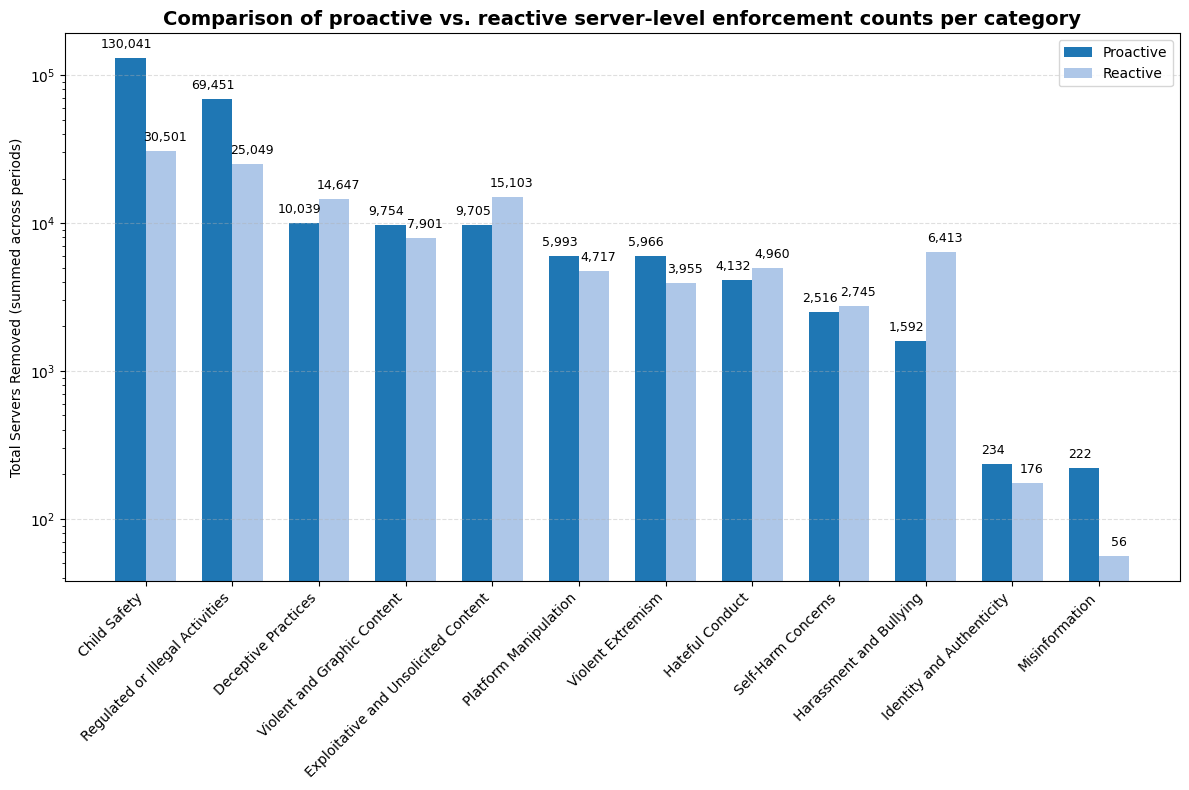

In [28]:
all_servers_removed = {
    row.period: row.dataframes.get("Servers Removed")
    for _, row in master_df.iterrows()
    if "Servers Removed" in row.dataframes
}

def aggregate_servers_removed(all_servers_removed: dict):
    rows = []
    for period, df in all_servers_removed.items():
        if df is None or getattr(df, "empty", True):
            continue
        d = df.copy()
        d.columns = [c.strip() for c in d.columns]

        # detect column names
        cat_col = next((c for c in d.columns if "category" in c.lower()), None)
        pro_col = next((c for c in d.columns if "proactive" in c.lower()), None)
        rea_col = next((c for c in d.columns if "reactive" in c.lower()), None)
        if not (cat_col and pro_col and rea_col):
            # skip if expected columns not found
            continue

        d = d[[cat_col, pro_col, rea_col]].copy()
        # clean numbers
        d[pro_col] = pd.to_numeric(d[pro_col].astype(str).str.replace(",", ""), errors="coerce").fillna(0).astype(int)
        d[rea_col] = pd.to_numeric(d[rea_col].astype(str).str.replace(",", ""), errors="coerce").fillna(0).astype(int)
        d[cat_col] = d[cat_col].astype(str)
        # drop totals/summary rows
        d = d[~d[cat_col].str.contains("total", case=False, na=False)]
        d["period"] = period

        rows.append(d.rename(columns={cat_col: "category", pro_col: "proactive", rea_col: "reactive"}))

    if not rows:
        return pd.DataFrame(columns=["category", "proactive", "reactive"]), pd.DataFrame()

    all_df = pd.concat(rows, ignore_index=True, sort=False)
    # aggregate by category summing over periods
    agg = all_df.groupby("category", as_index=False)[["proactive", "reactive"]].sum()
    return agg, all_df

agg_df, all_rows_df = aggregate_servers_removed(all_servers_removed)

# plot grouped bar chart (two bars per category)
if not agg_df.empty:
    agg_df = agg_df.sort_values(by=["proactive", "reactive"], ascending=False).reset_index(drop=True)
    cats = agg_df["category"].tolist()
    proactive = agg_df["proactive"].values
    reactive = agg_df["reactive"].values

    x = np.arange(len(cats))
    width = 0.35

    cmap = plt.get_cmap('tab20')

    fig, ax = plt.subplots(figsize=(12, 8))

    # Use the first two colors from the colormap for Proactive & Reactive
    color_pro = cmap(0)
    color_rea = cmap(1)

    b1 = ax.bar(x - width/2, proactive, width, label="Proactive", color=color_pro)
    b2 = ax.bar(x + width/2, reactive, width, label="Reactive", color=color_rea)

    ax.set_xticks(x)
    ax.set_xticklabels(cats, rotation=45, ha="right", fontsize=10)
    ax.set_ylabel("Total Servers Removed (summed across periods)")
    ax.set_title("Comparison of proactive vs. reactive server-level enforcement counts per category",  fontsize=14, weight='bold')
    ax.set_yscale("log")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    # annotate
    def annotate(bars, x_offset=0):
        for bar in bars:
            h = int(bar.get_height())
            ax.annotate(f"{h:,}",
                        xy=(bar.get_x() + bar.get_width()/2 + x_offset, h),
                        xytext=(0, 5), textcoords="offset points",
                        ha="center", va="bottom", fontsize=9)

    # Offset the x-position slightly to avoid overlapping labels
    annotate(b1, x_offset=-0.05)
    annotate(b2, x_offset=0.05)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "discord_proactive_vs_reactive_servers.png"), dpi=300)
    plt.show()

### Statistical test of independence
p < 0.05 → reject the null hypothesis → detection type depends on category (some categories are disproportionately proactive/reactive)

p ≥ 0.05 → fail to reject → enforcement is independent of category

In [29]:
contingency = agg_df[["proactive", "reactive"]]

chi2, p, dof, expected = chi2_contingency(contingency)

print(f"Chi-squared: {chi2:.2f}")
print(f"p-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")

# Show expected counts under the null hypothesis of independence
expected_df = pd.DataFrame(expected, index=agg_df["category"], columns=["proactive", "reactive"])
print("Expected counts under independence:")
print(expected_df)

print("\n")
if contingency.shape == (2, 2):
    table = contingency.values.astype(int)
    oddsratio, p = fisher_exact(table)
    print(f"Fisher exact odds ratio: {oddsratio:.3f}")
    print(f"p-value: {p:.4f}")
else:
    # For R x 2 table, run Fisher (2x2) per category vs rest and adjust p-values
    total_pro = int(contingency["proactive"].sum())
    total_rea = int(contingency["reactive"].sum())

    rows = []
    for _, r in agg_df.iterrows():
        a = int(r["proactive"] or 0)   # proactive in category
        b = int(r["reactive"] or 0)    # reactive in category
        c = total_pro - a              # proactive in other categories
        d = total_rea - b              # reactive in other categories
        table = np.array([[a, b], [c, d]])
        try:
            oddsratio, p = fisher_exact(table)
        except Exception:
            oddsratio, p = np.nan, np.nan
        rows.append({"category": r["category"], "oddsratio": oddsratio, "pvalue": p, "table": table.tolist()})

    res_df = pd.DataFrame(rows).sort_values("pvalue")
    # multiple testing correction (Benjamini-Hochberg)
    res_df["p_adj"] = multipletests(res_df["pvalue"].fillna(1.0), method="fdr_bh")[1]
    pd.set_option("display.max_rows", 200)
    print("Per-category Fisher exact tests (category vs rest):")
    print(res_df[["category", "oddsratio", "pvalue", "p_adj"]].to_string(index=False))

Chi-squared: 45915.92
p-value: 0.0000
Degrees of freedom: 11
Expected counts under independence:
                                          proactive      reactive
category                                                         
Child Safety                          109543.626636  50998.373364
Regulated or Illegal Activities        64480.775854  30019.224146
Deceptive Practices                    16844.152727   7841.847273
Violent and Graphic Content            12046.646536   5608.353464
Exploitative and Unsolicited Content   16927.397750   7880.602250
Platform Manipulation                   7307.821263   3402.178737
Violent Extremism                       6769.457960   3151.542040
Hateful Conduct                         6203.801207   2888.198793
Self-Harm Concerns                      3589.771024   1671.228976
Harassment and Bullying                 5462.101701   2542.898299
Identity and Authenticity                279.757863    130.242137
Misinformation                           189.

## SUBQ2:

In [30]:
all_periods_df = build_all_periods_df_from_master(master_df)

all_periods_df.head()

,period,policy_category,servers_removed,proactive,reactive,proactive_share,reactive_share,period_id
0,July - December 2021,Child Safety,17017,5640,11377,0.331433,0.668567,1
1,July - December 2021,Deceptive Practices,6601,1006,5595,0.152401,0.847599,1
2,July - December 2021,Exploitative and Unsolicited Content,7604,1512,6092,0.198843,0.801157,1
3,July - December 2021,Harassment and Bullying,1867,258,1609,0.138190,0.861810,1
4,July - December 2021,Hateful Conduct,2772,881,1891,0.317821,0.682179,1


In [31]:
dmap = {
    "period": "Report period label (e.g. 'July - December 2021')",
    "policy_category": "Policy violation category / label (e.g. 'Child Safety')",
    "servers_removed": "Total servers removed for this category in the period (integer)",
    "proactive": "Servers removed by proactive enforcement actions (integer)",
    "reactive": "Servers removed by reactive enforcement actions (integer)",
    "proactive_share": "proportion proactive / servers_removed (float, 0-1)",
    "reactive_share": "proportion reactive / servers_removed (float, 0-1)",
    "period_id": "Chronological integer id for the period (1 = earliest)"
}

print("Dataset shape: ", all_periods_df.shape)

summary = summarize_df_columns(all_periods_df, desc_map=dmap)
print(summary.to_markdown(index=False))
# print("\n")
# latex_df = summary.copy()
# if "pct_missing" in latex_df.columns:
#     latex_df["pct_missing"] = latex_df["pct_missing"].astype(str).str.replace("%", r"\%", regex=False)

# print(latex_df.to_latex(index=False, escape=False))


Dataset shape:  (118, 8)
| column          | dtype   |   n_missing | pct_missing   |   n_unique | description                                                     |
|:----------------|:--------|------------:|:--------------|-----------:|:----------------------------------------------------------------|
| period          | object  |           0 | 0.0%          |         10 | Report period label (e.g. 'July - December 2021')               |
| policy_category | object  |           0 | 0.0%          |         12 | Policy violation category / label (e.g. 'Child Safety')         |
| servers_removed | Int64   |           0 | 0.0%          |        112 | Total servers removed for this category in the period (integer) |
| proactive       | Int64   |           0 | 0.0%          |        109 | Servers removed by proactive enforcement actions (integer)      |
| reactive        | Int64   |          12 | 10.2%         |        102 | Servers removed by reactive enforcement actions (integer)       |
| 

/var/folders/69/6nn2sm8d7qq0p98t_qgp1ckr0000gn/T/ipykernel_89670/304179438.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  updates = pd.to_datetime(update_strs, dayfirst=True, errors='coerce')
/var/folders/69/6nn2sm8d7qq0p98t_qgp1ckr0000gn/T/ipykernel_89670/304179438.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  reports = pd.to_datetime(report_strs, dayfirst=True, errors='coerce')


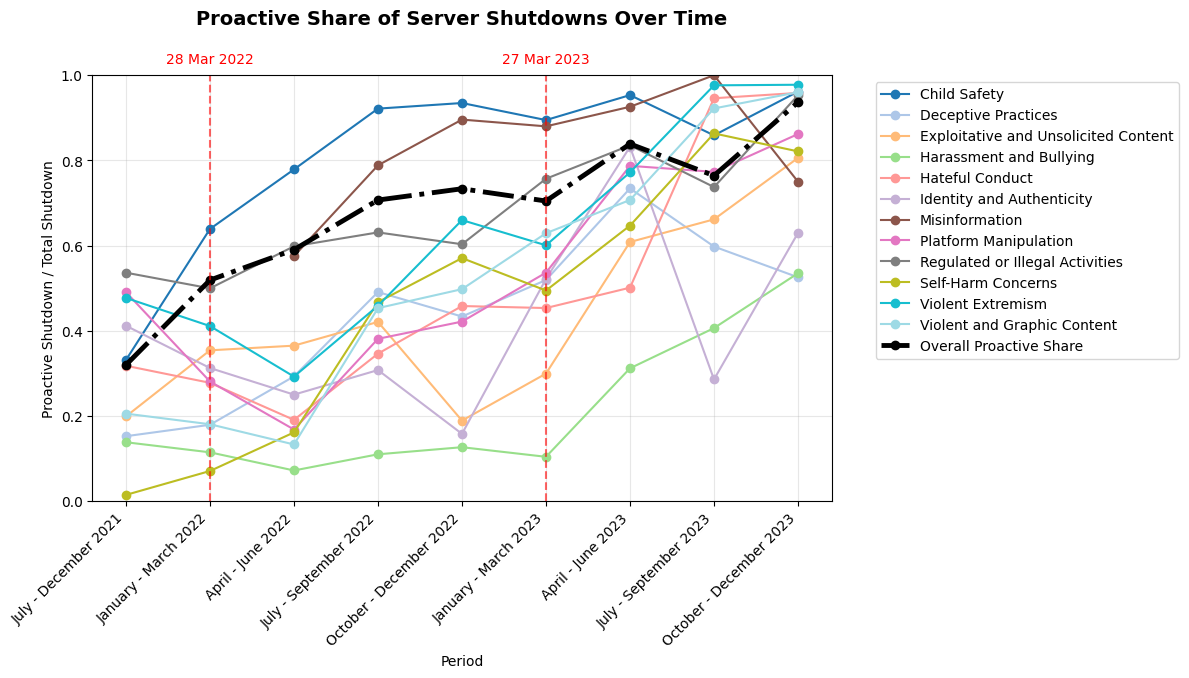

In [32]:
df = all_periods_df[all_periods_df["period"] != "January - June 2024"]
pivot_df = df.pivot(index='period_id', columns='policy_category', values='proactive_share')

# compute aggregate line indifferent of category
agg_df = df.groupby('period_id')[['proactive', 'reactive']].sum(min_count=1)
agg_df['proactive_share'] = agg_df['proactive'] / (agg_df['proactive'] + agg_df['reactive'])

plt.figure(figsize=(12, 7))
cmap = plt.get_cmap('tab20', len(pivot_df.columns))  # or 'tab20b', 'tab20c', 'viridis', etc.

for i, col in enumerate(pivot_df.columns):
    plt.plot(pivot_df.index, pivot_df[col], marker='o', label=col, color=cmap(i))

# plot aggregate line
plt.plot(
    agg_df.index, agg_df['proactive_share'],
    color='black', linewidth=3.5, marker='o', linestyle='dashdot',
    label='Overall Proactive Share'
)

# map period_id -> original period string (preserve chronological order)
id_to_label = (all_periods_df[['period_id', 'period']]
               .drop_duplicates(subset=['period_id'])
               .set_index('period_id')['period']
               .to_dict())

# build mapping period_id -> start Timestamp
period_dates = {int(pid): period_start_ts(lbl) for pid, lbl in id_to_label.items()}

# event dates (your list) -> parse with dayfirst=True
update_strs = ["7 may 2020", "28 march 2022", "27 march 2023", "15 april 2024", "29 sept 2025"]
updates = pd.to_datetime(update_strs, dayfirst=True, errors='coerce')

report_strs = ["30 june 22", "28 october 2022", "15 dec 2022", "13 july 2023", "3 october 2023"]
reports = pd.to_datetime(report_strs, dayfirst=True, errors='coerce')

# plot vertical lines only for events inside the timeline
sorted_pids = sorted(period_dates.keys())
first = period_dates[sorted_pids[0]]
last = period_dates[sorted_pids[-1]]  # final period span handled below

# plot updates (red, dashed)
for ev, ev_raw in zip(updates, update_strs):
    if pd.isna(ev):
        continue
    if not (first <= ev < last):
        continue
    x_pos = None
    for i, pid in enumerate(sorted_pids):
        start = period_dates[pid]
        end = period_dates[sorted_pids[i+1]] if i + 1 < len(sorted_pids) else start + pd.DateOffset(months=6)
        if start <= ev < end:
            x_pos = pid
            break
    if x_pos is None:
        continue
    plt.axvline(x=x_pos, color='r', linestyle='--', alpha=0.6)
    plt.text(x_pos, 1.02, ev.strftime('%d %b %Y'), va='bottom', ha='center', transform=plt.gca().get_xaxis_transform(), color='r')

# # plot reports (blue, dashdot)
# for ev, ev_raw in zip(reports, report_strs):
#     if pd.isna(ev):
#         continue
#     if not (first <= ev < last):
#         continue
#     x_pos = None
#     for i, pid in enumerate(sorted_pids):
#         start = period_dates[pid]
#         end = period_dates[sorted_pids[i+1]] if i + 1 < len(sorted_pids) else start + pd.DateOffset(months=6)
#         if start <= ev < end:
#             x_pos = pid
#             break
#     if x_pos is None:
#         continue
#     plt.axvline(x=x_pos, color='tab:blue', linestyle='-.', alpha=0.7)
#     plt.text(x_pos, 1.05, ev.strftime('%d %b %Y'), va='bottom', ha='center', transform=plt.gca().get_xaxis_transform(), color='tab:blue')

# build labels for the x ticks in the same order as pivot_df.index
handles, labels = plt.gca().get_legend_handles_labels()
proxy_updates = Line2D([0], [0], color='r', linestyle='--', label='Updates')
# proxy_reports = Line2D([0], [0], color='tab:blue', linestyle='-.', label='Reports')

plt.title("Proactive Share of Server Shutdowns Over Time", fontsize=14, weight='bold', y=1.1)
plt.xlabel("Period")
plt.ylabel("Proactive Shutdown / Total Shutdown")
# map period id back to original period strings for x-ticks
xtick_labels = [id_to_label.get(pid, str(pid)) for pid in pivot_df.index]
plt.xticks(ticks=pivot_df.index, labels=xtick_labels, rotation=45, ha='right', fontsize=10)
plt.ylim(0, 1)
plt.legend(handles=handles + [proxy_updates], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig(os.path.join(output_dir, "discord_proactive_share_over_time.png"), dpi=300)
plt.show()

### OLS on timeseries

In [14]:
trend_results = []
window = 2  # Number of periods before/after each red line to include

# Define your red line periods
red_lines = {'2022-03-28': 2, '2023-03-27': 6}

agg_df = df.groupby('period_id')[['proactive', 'reactive']].sum(min_count=1)
agg_df['proactive_share'] = agg_df['proactive'] / (agg_df['proactive'] + agg_df['reactive'])
agg_df = agg_df.reset_index()
agg_df['policy_category'] = 'ALL_CATEGORIES'  # label for aggregate line

# Combine aggregate line with category-level data
combined_df = pd.concat([df, agg_df], ignore_index=True, sort=False)

for cat, sub in combined_df.groupby('policy_category'):
    sub = sub.sort_values('period_id')
    x = np.arange(len(sub))
    y = sub['proactive_share']
    
    # --- Overall trend ---
    if len(x) > 1 and y.notna().all():
        slope, intercept, r, p, _ = linregress(x, y)
        trend_results.append({
            'policy_category': cat,
            'window': 'overall',
            'slope': slope,
            'r_value': r,
            'p_value': p
        })
    

    # --- Localized trends around each red line ---
    for date_label, red_period in red_lines.items():
        before = sub[(sub['period_id'] >= red_period - window) & (sub['period_id'] < red_period)]
        after  = sub[(sub['period_id'] > red_period) & (sub['period_id'] <= red_period + window)]
        
        # Regressions before and after
        if len(before) > 1 and before['proactive_share'].notna().all():
            xb = np.arange(len(before))
            yb = before['proactive_share']
            slope_b, _, rb, pb, _ = linregress(xb, yb)
            trend_results.append({
                'policy_category': cat,
                'window': f'before_{date_label}',
                'slope': slope_b,
                'r_value': rb,
                'p_value': pb
            })
        
        if len(after) > 1 and after['proactive_share'].notna().all():
            xa = np.arange(len(after))
            ya = after['proactive_share']
            slope_a, _, ra, pa, _ = linregress(xa, ya)
            trend_results.append({
                'policy_category': cat,
                'window': f'after_{date_label}',
                'slope': slope_a,
                'r_value': ra,
                'p_value': pa
            })

trend_df = pd.DataFrame(trend_results)

# Pivot slopes and p-values separately
slope_pivot = trend_df.pivot(index='policy_category', columns='window', values='slope')
pval_pivot = trend_df.pivot(index='policy_category', columns='window', values='p_value')

# Add missing columns
for col in ['before_2022-03-28', 'after_2022-03-28', 'before_2023-03-27', 'after_2023-03-27', 'overall']:
    for df_ in [slope_pivot, pval_pivot]:
        if col not in df_.columns:
            df_[col] = np.nan

# Compute slope differences
change_df = slope_pivot.assign(
    change_2022=lambda d: d['after_2022-03-28'] - d['before_2022-03-28'],
    change_2023=lambda d: d['after_2023-03-27'] - d['before_2023-03-27']
)
p_change_df = pval_pivot.assign(
    p_change_2022=lambda d: np.nan,  # not calculated, placeholder
    p_change_2023=lambda d: d['after_2023-03-27']  # use p-value of "after" as approximate
)

final_df = pd.DataFrame({
    'overall_slope': slope_pivot['overall'],
    # 'overall_pval': pval_pivot['overall'],
    'change_2023_slope': change_df['change_2023'],
    # 'change_2023_pval': p_change_df['p_change_2023']
})

print("\n=== Final Trend Table (slopes and p-values) ===")
final_df.sort_values('overall_slope', ascending=False).round(4)

# to latex
latex_df = final_df.reset_index()
latex_df = latex_df.rename(columns={
    'policy_category': 'Policy Category',
    'overall_slope': 'Overall Slope',
    # 'overall_pval': '$p$',
    'change_2023_slope': '$\delta$ Slope (2023)',
    # 'change_2023_pval': '$p$'
})
print(latex_df.to_latex(index=False, float_format="%.3f", escape=False))


=== Final Trend Table (slopes and p-values) ===
\begin{tabular}{lrr}
\toprule
Policy Category & Overall Slope & $\delta$ Slope (2023) \\
\midrule
ALL_CATEGORIES & 0.062 & -0.101 \\
Child Safety & 0.058 & -0.108 \\
Deceptive Practices & 0.061 & -0.079 \\
Exploitative and Unsolicited Content & 0.062 & 0.285 \\
Harassment and Bullying & 0.049 & 0.078 \\
Hateful Conduct & 0.088 & 0.333 \\
Identity and Authenticity & 0.036 & -0.396 \\
Misinformation & 0.035 & -0.033 \\
Platform Manipulation & 0.073 & -0.055 \\
Regulated or Illegal Activities & 0.050 & -0.070 \\
Self-Harm Concerns & 0.110 & 0.113 \\
Violent Extremism & 0.080 & 0.003 \\
Violent and Graphic Content & 0.109 & 0.170 \\
\bottomrule
\end{tabular}



<>:100: SyntaxWarning: invalid escape sequence '\d'
<>:100: SyntaxWarning: invalid escape sequence '\d'
/var/folders/69/6nn2sm8d7qq0p98t_qgp1ckr0000gn/T/ipykernel_89670/2739508041.py:100: SyntaxWarning: invalid escape sequence '\d'
  'change_2023_slope': '$\delta$ Slope (2023)',


### OLS with slope per year metric instead of per reporting period

In [18]:
trend_results = []
window = 2  # Number of periods before/after each red line to include

# Define red line (policy update) periods
red_lines = {'2022-03-28': 2, '2023-03-27': 6}

# Aggregate proactive/reactive over all categories for the overall line
agg_df = df.groupby('period_id')[['proactive', 'reactive']].sum(min_count=1)
agg_df['proactive_share'] = agg_df['proactive'] / (agg_df['proactive'] + agg_df['reactive'])
agg_df = agg_df.reset_index()
agg_df['policy_category'] = 'ALL_CATEGORIES'

# Combine with category-level data
combined_df = pd.concat([df, agg_df], ignore_index=True, sort=False)

# === NEW: Convert each period_id into a numeric time axis (in days) ===
# We use your id_to_label -> period_start_ts() mapping from earlier
id_to_label = (all_periods_df[['period_id', 'period']]
               .drop_duplicates(subset=['period_id'])
               .set_index('period_id')['period']
               .to_dict())
period_dates = {int(pid): period_start_ts(lbl) for pid, lbl in id_to_label.items()}

# Add a 'date' column for each record based on period_id
combined_df['date'] = combined_df['period_id'].map(period_dates)

# Sort by time
combined_df = combined_df.sort_values(['policy_category', 'date'])

for cat, sub in combined_df.groupby('policy_category'):
    sub = sub.dropna(subset=['proactive_share', 'date']).sort_values('date')
    
    # Convert to numeric x-axis in days relative to first period
    sub['days_since_start'] = (sub['date'] - sub['date'].min()).dt.days
    x = sub['days_since_start'].to_numpy()
    y = sub['proactive_share'].to_numpy()
    
    # --- Overall trend (per day) ---
    if len(x) > 1:
        slope_day, intercept, r, p, _ = linregress(x, y)
        slope_year = slope_day * 365  # convert to per year
        trend_results.append({
            'policy_category': cat,
            'window': 'overall',
            'slope_per_day': slope_day,
            'slope_per_year': slope_year,
            'r_value': r,
            'p_value': p
        })

    # --- Localized trends around each red line ---
    for date_label, red_period in red_lines.items():
        before = sub[(sub['period_id'] >= red_period - window) & (sub['period_id'] < red_period)]
        after  = sub[(sub['period_id'] > red_period) & (sub['period_id'] <= red_period + window)]
        
        if len(before) > 1:
            xb = (before['date'] - sub['date'].min()).dt.days
            yb = before['proactive_share']
            slope_b, _, rb, pb, _ = linregress(xb, yb)
            trend_results.append({
                'policy_category': cat,
                'window': f'before_{date_label}',
                'slope_per_day': slope_b,
                'slope_per_year': slope_b * 365,
                'r_value': rb,
                'p_value': pb
            })
        
        if len(after) > 1:
            xa = (after['date'] - sub['date'].min()).dt.days
            ya = after['proactive_share']
            slope_a, _, ra, pa, _ = linregress(xa, ya)
            trend_results.append({
                'policy_category': cat,
                'window': f'after_{date_label}',
                'slope_per_day': slope_a,
                'slope_per_year': slope_a * 365,
                'r_value': ra,
                'p_value': pa
            })

trend_df = pd.DataFrame(trend_results)

# Pivot slopes and p-values separately (per year for interpretability)
slope_pivot = trend_df.pivot(index='policy_category', columns='window', values='slope_per_year')
pval_pivot = trend_df.pivot(index='policy_category', columns='window', values='p_value')

# Add missing columns for consistency
for col in ['before_2022-03-28', 'after_2022-03-28', 'before_2023-03-27', 'after_2023-03-27', 'overall']:
    for df_ in [slope_pivot, pval_pivot]:
        if col not in df_.columns:
            df_[col] = np.nan

# Compute slope differences (per year)
change_df = slope_pivot.assign(
    change_2022=lambda d: d['after_2022-03-28'] - d['before_2022-03-28'],
    change_2023=lambda d: d['after_2023-03-27'] - d['before_2023-03-27']
)

final_df = pd.DataFrame({
    'overall_slope_per_year': slope_pivot['overall'],
    # 'overall_pval': pval_pivot['overall'],
    'change_2023_slope_per_year': change_df['change_2023'],
    # 'change_2023_pval': p_change_df['p_change_2023']
}).reset_index()


# Export to LaTeX
latex_df = final_df.rename(columns={
    'policy_category': 'Policy Category',
    'overall_slope_per_year': 'Overall Slope (per year)',
    'change_2023_slope_per_year': r'$\Delta$Slope (2023, per year)'
})

print(latex_df.to_latex(index=False, float_format="%.3f", escape=False))


\begin{tabular}{lrr}
\toprule
Policy Category & Overall Slope (per year) & $\Delta$Slope (2023, per year) \\
\midrule
ALL_CATEGORIES & 0.236 & -0.403 \\
Child Safety & 0.231 & -0.431 \\
Deceptive Practices & 0.229 & -0.319 \\
Exploitative and Unsolicited Content & 0.229 & 1.133 \\
Harassment and Bullying & 0.175 & 0.313 \\
Hateful Conduct & 0.318 & 1.340 \\
Identity and Authenticity & 0.126 & -1.597 \\
Misinformation & 0.140 & -0.129 \\
Platform Manipulation & 0.255 & -0.217 \\
Regulated or Illegal Activities & 0.181 & -0.282 \\
Self-Harm Concerns & 0.409 & 0.458 \\
Violent Extremism & 0.287 & 0.021 \\
Violent and Graphic Content & 0.400 & 0.686 \\
\bottomrule
\end{tabular}



### Mean proactive share per category over full reporting period

In [40]:
# Exclude unwanted periods if needed
df_filtered = all_periods_df[all_periods_df["period"] != "January - June 2024"]

# Pivot to get proactive per category
pivot_proactive = df_filtered.pivot(index='period_id', columns='policy_category', values='proactive')
pivot_reactive = df_filtered.pivot(index='period_id', columns='policy_category', values='reactive')

# Sum over all periods to get totals per category
total_proactive = pivot_proactive.sum()
total_reactive = pivot_reactive.sum()
total_shutdowns = total_proactive + total_reactive
proactive_share = total_proactive / total_shutdowns

# Combine into a single DataFrame
summary_df = pd.DataFrame({
    'Violation Category': total_proactive.index,
    'Total': total_shutdowns.values,
    'Automated': total_proactive.values,
    'Manual': total_reactive.values,
    'Proactive_Share': proactive_share.values
})

# Sort by Proactive_Share descending
summary_df = summary_df.sort_values('Proactive_Share', ascending=False)

# Generate LaTeX table
latex_table = summary_df.to_latex(
    index=False,
    caption="Proactive Share of Server Shutdowns per Violation Category Over Full Time Period",
    label="tab:proactive_share_category",
    column_format="lrrrr",
    float_format="%.3f",
)

print(latex_table)

# Save LaTeX table
with open("../tables/discord_proactive_share_by_category.tex", "w") as f:
    f.write(latex_table)


\begin{table}
\caption{Proactive Share of Server Shutdowns per Violation Category Over Full Time Period}
\label{tab:proactive_share_category}
\begin{tabular}{lrrrr}
\toprule
Violation Category & Total & Automated & Manual & Proactive_Share \\
\midrule
Child Safety & 160542 & 130041 & 30501 & 0.810 \\
Misinformation & 278 & 222 & 56 & 0.799 \\
Regulated or Illegal Activities & 94500 & 69451 & 25049 & 0.735 \\
Violent Extremism & 9921 & 5966 & 3955 & 0.601 \\
Identity and Authenticity & 410 & 234 & 176 & 0.571 \\
Platform Manipulation & 10710 & 5993 & 4717 & 0.560 \\
Violent and Graphic Content & 17655 & 9754 & 7901 & 0.552 \\
Self-Harm Concerns & 5261 & 2516 & 2745 & 0.478 \\
Hateful Conduct & 9092 & 4132 & 4960 & 0.454 \\
Deceptive Practices & 24686 & 10039 & 14647 & 0.407 \\
Exploitative and Unsolicited Content & 24808 & 9705 & 15103 & 0.391 \\
Harassment and Bullying & 8005 & 1592 & 6413 & 0.199 \\
\bottomrule
\end{tabular}
\end{table}

